##### Nathan Lichtlé - Alain Riou - Robin San Roman
$%useful latex symbols$
$\newcommand{\(}{\left(}$
$\newcommand{\)}{\right)}$
$\newcommand{\GG}{\mathcal{G}}$
$\newcommand{\HH}{\mathcal{H}}$
$\newcommand{\JJ}{\mathbb{J}}$
$\newcommand{\NN}{\mathbb{N}}$
$\newcommand{\RR}{\mathbb{R}}$
$\newcommand{\argmin}[1]{\underset{#1}{\arg \min}\;}$
$\newcommand{\argmax}[1]{\underset{#1}{\arg \max}\;}$
$\newcommand{\df}[2]{\frac{\partial #1}{\partial #2}}$

# Image reconstruction in X-ray tomography

In [0]:
# imports
import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse
import scipy.sparse.linalg as linalg
from scipy.io import loadmat
import time

plt.rcParams['figure.figsize'] = (5,5)

## 1. X-ray tomography

X-ray tomography reconstructs dense volumes of objects from a set of projections measured at different angles. The measurements $y \in \RR^M$ and the sought absorption image $\bar{x} \in \RR^N$ obey the linear relation

$$\begin{equation}
y = H\bar{x} + w
\tag{1}
\end{equation}$$

where $w \in \RR^M$ is the measurement noise, that we assume i.i.d. Gaussian with variance $\sigma^2$. The tomography matrix $H \in \RR^{M \times N}$ is sparse and encodes the geometry of the measurements. Here, we will focus on the case when H models parallel projections of a 2-D object $\bar{x}$. Tomography measures are acquired at fixed and regularly sampled rotational positions between the sample and the detector so that $H_{m,n}$ models the intersection length between the $m$th light-ray and the $n$th pixel. If $N_\theta$ is the number of different angular positions of the detector in Fig. 1 and $L$ the linear size of the detector, the number of measurements $M = L \times N_\theta$. In practice, the angular positions are regularly distributed on $[0, \pi)$.

<img src="TP3_fig.png" alt="Drawing" style="width: 400px;"/>
<center>Figure 1 – Considered tomographic acquisition model<center/>

Traditional reconstruction methods such as the Filtered Back-Projection require the linear system $(1)$ to be sufficiently determined for good results, i.e., $N_\theta \sim L$.

However, several applications could benefit from a smaller number of projections, either in order to reduce the total dose for medical applications, or to reduce the total acquisition time for in-situ experiments where the sample is evolving. Therefore, more sophisticated reconstruction approaches must be developed in order to overcome the under-determinacy of the problem and to make it robust to the presence of noise in the measurements.

1. Download the projection matrix $H$ and the image $\bar{x}$ available on the website. Use `loadmat` from `scipy.io` in Python to load the arrays, note that $H$ is stored as a sparse matrix.

In [0]:
!wget -nc --user ECP --password Optim http://www-syscom.univ-mlv.fr/~chouzeno/ECP/Slides/data.zip
!unzip -n data.zip

H = loadmat('data/H.mat')['H']
xbar = loadmat('data/x.mat')['x'].reshape(-1)
print('Done.')

--2019-12-27 01:43:13--  http://www-syscom.univ-mlv.fr/~chouzeno/ECP/Slides/data.zip
Resolving www-syscom.univ-mlv.fr (www-syscom.univ-mlv.fr)... 193.55.63.149
Connecting to www-syscom.univ-mlv.fr (www-syscom.univ-mlv.fr)|193.55.63.149|:80... connected.
HTTP request sent, awaiting response... 401 Unauthorized
Authentication selected: Basic realm="Acces Restreint"
Reusing existing connection to www-syscom.univ-mlv.fr:80.
HTTP request sent, awaiting response... 200 OK
Length: 28966183 (28M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]  27.62M  85.9MB/s    in 0.3s    

2019-12-27 01:43:14 (85.9 MB/s) - ‘data.zip’ saved [28966183/28966183]

Archive:  data.zip
   creating: data/
  inflating: data/G.mat              
  inflating: data/H.mat              
  inflating: data/x.mat              
Done.


2. Construct $y$, according to model $(1)$, using $\sigma = 1$.

In [0]:
M, N = H.shape
threshold = np.sqrt(N)*1e-4 # see part 3.6
w = np.random.normal(0,1,M)
y = H @ xbar + w

3. Here, $N = 90 \times 90$ pixels and $M = 90 \times 180$ measurements. Display a 2D version of $\bar{x}$ and a 2D version of $y$, also known as sinogram. To do so, in Matlab, use the `reshape` function; in Python, use the `reshape` method with option `order=’F’`.

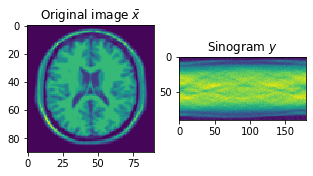

In [0]:
plt.figure(figsize=(5,10))
plt.subplot(1,2,1)
plt.imshow(xbar.reshape(90,90, order='F'))
plt.title('Original image $\\bar{x}$')
plt.subplot(1,2,2)
plt.imshow(y.reshape(90,180, order='F'))
plt.title('Sinogram $y$')
plt.show()

## 2. Optimization problem

An efficient strategy to address the reconstruction problem is to define $x$ as a minimizer of an appropriate cost function $f$. More specifically, we focus on the following penalized least-squares criterion:

$$\begin{equation}
\forall x \in \RR^N, \ f(x) = \frac{1}{2} \|Hx - y \|^2 + \lambda r(x)
\tag{2}
\end{equation}$$

where $r$ is a regularization function incorporating *a priori* assumptions to guarantee the robustness of the solution with respect to noise. In order to promote images formed by smooth regions separated by sharp edges, we set

$$\begin{equation}
\forall x \in \RR^N, \ r(x) = \sum_{n=1}^{2N} \psi \( [Gx]^{(n)} \)
\tag{3}
\end{equation}$$

where $G \in \RR^{2N \times N}$ is a sparse matrix such that $Gx \in \RR^{2N}$ is the concatenation of the horizontal and vertical gradients of the image, and $\psi$ is a potential function defined
as:

$$\begin{equation}
\psi(u) = \sqrt{1 + u^2/\delta^2}
\tag{4}
\end{equation}$$

with some parameter $\delta > 0$ aiming at guaranteeing the differentiability of $r$. In the following, we will set $(\lambda, \delta) = (0.13, 0.02)$.

1. Download the gradient operator $G$ available in the website.

In [0]:
!wget -nc --user ECP --password Optim http://www-syscom.univ-mlv.fr/~chouzeno/ECP/Slides/data.zip
!unzip -n data.zip

G = loadmat('data/G.mat')['G']
print('Done.')

File ‘data.zip’ already there; not retrieving.

Archive:  data.zip
Done.


2. Give the expression of the gradient $\nabla f$ at some point $x \in \RR^N$. Create a function which gives as an output the gradient of $f$ at some input vector $x$.

$$\df{}{x} \| Hx - y \|^2 = 2 H^\top \( Hx - y \)$$

Moreover, for $n \in \{1, \dots, 2N \}$:
$$\begin{aligned}
\df{\psi\( [Gx]^{(n)} \)}{x}
&= \df{\psi \([Gx]^{(n)} \)}{[Gx]^{(n)}} \df{[Gx]^{(n)}}{x} & \text{using the chain rule} \\
&= \df{\psi(u)}{u} \df{g_n^\top x}{x} & \text{where $g_n^\top$ denotes the $n$-th row of $G$} \\
&= \frac{[Gx]^{(n)}}{\delta^2 \psi \( [Gx]^{(n)} \)} g_n
\end{aligned}$$

Hence, by linearity, for $x \in \RR^N$:
$$\begin{aligned}
\nabla f(x)
&= H^\top \( Hx - y \) + \frac{\lambda}{\delta^2} \( \sum_{n=1}^{2N} \frac{[Gx]^{(n)}}{\psi \( [Gx]^{(n)} \) }
g_n \) \\
&= H^\top \( Hx - y \) + \frac{\lambda}{\delta^2} G^\top \widetilde{g}(x)
\end{aligned}$$
where $\widetilde{g}^{(n)}(x) = \frac{[Gx]^{(n)}}{\psi \( [Gx]^{(n)} \) }$ for all $n \in \{1, \dots, 2N \}$.

3. Show that a Lipschitz constant of $\nabla f$ is
$$L = \|H\|^2 + \(\lambda / \delta^2 \) \|G\|^2$$
Calculate it for the $(\lambda, \delta)$ values given above. Note that, in Matlab, one can use `normest` to evaluate the norm of a sparse matrix ; in Python, the function `scipy.sparse.linalg.svds` gives the singular values of a sparse matrix, the maximal singular value being the norm of the matrix.

Let $x, x' \in \RR^N$.

$$\begin{aligned}
\left\|H^\top \( Hx - y \) - H^\top \( Hx' - y \) \right\|
&= \left\| H^\top H (x - x') \right\| \\
&\leq \left\| H^\top H \right\| \left\| x - x' \right\| \\
&= \|H\|^2 \|x - x'\|
\end{aligned}$$

For $n \in \{1, \dots, 2N \}$:
$$\begin{aligned}
\left\| G^\top \widetilde{g}(x) - G^\top \widetilde{g}(x') \right\|
&= \left\| G^\top \( \widetilde{g}(x) - \widetilde{g}(x') \) \right\| \\
&= \left\| G^\top G \( \frac{x}{\psi(Gx)} - \frac{x'}{\psi(Gx')} \) \right\| \\
&\leq \left\| G^\top G \right\| \left\| \frac{x}{\psi(Gx)} - \frac{x'}{\psi(Gx')} \right\| \\
&\leq \|G\|^2 \|x - x'\| \quad \text{ since } \forall x, \|\psi(Gx) \| \leq 1
\end{aligned}$$

Hence, by triangle inequality,
$$\begin{aligned}
\| \nabla f(x) - \nabla f(x') \|
&= \left\|H^\top \( Hx - y \) - H^\top \( Hx' - y \) + \frac{\lambda}{\delta^2} \(G^\top \widetilde{g}(x) - G^\top \widetilde{g}(x') \) \right\| \\
&\leq \left\|H^\top \( Hx - y \) - H^\top \( Hx' - y \) \right\| + \frac{\lambda}{\delta^2} \left\| G^\top \widetilde{g}(x) - G^\top \widetilde{g}(x') \right\| \\
&\leq \( \| H \|^2 + \frac{\lambda}{\delta^2} \| G \|^2 \) \|x - x' \|
\end{aligned}$$
i.e.
$$L = \|H\|^2 + \frac{\lambda}{\delta^2} \|G\|^2$$

In [36]:
lbda, delta = 0.13, 0.02

_, H_eigvals, _ = linalg.svds(H)
_, G_eigvals, _ = linalg.svds(G)

print('L =', H_eigvals[-1]**2 + lbda/(delta**2)*G_eigvals[-1]**2)

L = 18092.77327686482


In [0]:
# decorator to save convergence speed of algorithms
def exc_time(func):
    def wrapped(*args, **kwargs):
        start = time.time()
        res = func(*args, **kwargs)
        d = time.time() - start
        np.save(func.__name__+'_time.npy', d)
        print('Time elapsed: {0:.0f}min {1:02.0f}s.'.format(*divmod(d, 60)))
        return res
    wrapped.__name__ = func.__name__
    return wrapped

## 3. Optimization algorithms

### 3.1 Gradient descent algorithm

1. Create $x_0 \in \RR^N$ a vector with all entries equal to 0. This will be our initialization for all tested algorithms.

In [0]:
x0 = np.zeros(N)

2. Implement a gradient descent algorithm to minimize $f$.

In [0]:
psi = lambda u: np.sqrt(1 + (u/delta)**2)

def f(x):
    norm = np.linalg.norm(H @ x - y)
    return norm**2 / 2.0 + lbda * np.sum(psi(G @ x))

def grad_f(x):
    Gx = G @ x
    grad = Gx / psi(Gx) @ G
    return H.T @ (H @ x - y) + lbda/(delta**2) * grad

@exc_time
def GD(x0, f, grad_f, n_iters=int(1e5), threshold=threshold, lr=1e-4):
    fx_lst = [f(x0)]
    x = np.copy(x0)
    for k in range(n_iters):
        x -= lr * grad_f(x)
        fx_lst.append(f(x))
        norm_grad_f = np.linalg.norm(grad_f(x))
        stopping = norm_grad_f <= threshold
        if k % 200 == 0 or k == n_iters-1 or stopping:
            print("iter {}:  \tf(x) = {:.5f}\t||∇f(x)|| = {:.5f}".format(k + 1, f(x), norm_grad_f))
        if stopping:
            print("stopping criterion reached, stopping now")
            break
    np.save('GD_values.npy', np.array(fx_lst))
    return x

In [0]:
x_gd = GD(x0, f, grad_f)

iter 1:  	f(x) = 2151597.18781	||∇f(x)|| = 247502.80814
iter 201:  	f(x) = 13002.66313	||∇f(x)|| = 55.17148
iter 401:  	f(x) = 12983.10015	||∇f(x)|| = 14.43905
iter 601:  	f(x) = 12981.38982	||∇f(x)|| = 5.15706
iter 801:  	f(x) = 12981.13783	||∇f(x)|| = 2.22708
iter 1001:  	f(x) = 12981.08631	||∇f(x)|| = 1.06918
iter 1201:  	f(x) = 12981.07388	||∇f(x)|| = 0.54135
iter 1401:  	f(x) = 12981.07060	||∇f(x)|| = 0.28392
iter 1601:  	f(x) = 12981.06968	||∇f(x)|| = 0.15316
iter 1801:  	f(x) = 12981.06940	||∇f(x)|| = 0.08467
iter 2001:  	f(x) = 12981.06932	||∇f(x)|| = 0.04785
iter 2201:  	f(x) = 12981.06929	||∇f(x)|| = 0.02757
iter 2401:  	f(x) = 12981.06928	||∇f(x)|| = 0.01617
iter 2601:  	f(x) = 12981.06928	||∇f(x)|| = 0.00963
iter 2628:  	f(x) = 12981.06928	||∇f(x)|| = 0.00899
stopping criterion reached, stopping now
Time elapsed: 1min 27s.


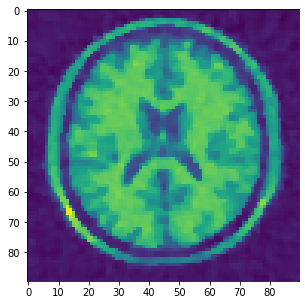

In [0]:
plt.imshow(x_gd.reshape(90,90, order='F'))
plt.show()

### 3.2 MM quadratic algorithm

1. Construct, for all $x \in \RR^N$, a quadratic majorant function of $f$ at $x$. Create a function which gives, as an output, the curvature $A(x)$ of the majorant function at an input vector x.
Hint : in Matlab, use `spdiags` to create a sparse diagonal matrix; in Python, use `scipy.sparse.diags(d[:,0]).tocsc()` to create a sparse matrix from a diagonal vector $d \in \RR^{n \times 1}$ using the compressed sparse column format. In addition, in Python, use the class `LinearOperator` from `scipy.sparse.linalg` to create the curvature operator.

In [0]:
HtH = H.T @ H
coef = lbda / (delta ** 2)

def A(x):
    diag = scipy.sparse.diags(1 / psi(G @ x)).tocsc()

    def curvature(v):
        return HtH @ v + coef * (G.T @ (diag @ (G @ v)))

    return linalg.LinearOperator((N, N), matvec=curvature, rmatvec=curvature)

2. Deduce a MM quadratic algorithm to minimize $f$. Implement it.
Hint : in Matlab use `pcg` to invert the majorant matrix at each iteration ; in Python, use `bicg` from `scipy.sparse.linalg`.

In [0]:
@exc_time
def MMQ(x0, f, grad_f, A, n_iters=int(1e5), threshold=threshold, lr=1):
    fx_lst = [f(x0)]
    x = np.copy(x0)
    for k in range(n_iters):
        x -= lr * linalg.bicg(A(x), grad_f(x))[0]
        fx_lst.append(f(x))
        norm_grad_f = np.linalg.norm(grad_f(x))
        stopping = norm_grad_f <= threshold
        if k % 10 == 0 or k == n_iters-1 or stopping:
            print("iter {}:  \tf(x) = {:.5f}\t||∇f(x)|| = {:.5f}".format(k + 1, f(x), norm_grad_f))
        if stopping:
            print("stopping criterion reached, stopping now")
            break
    np.save('MMQ_values.npy', np.array(fx_lst))
    return x

In [0]:
x_mmq = MMQ(x0, f, grad_f, A)

iter 1:  	f(x) = 15685.89740	||∇f(x)|| = 1256.40262
iter 11:  	f(x) = 12982.09937	||∇f(x)|| = 12.54897
iter 21:  	f(x) = 12981.09846	||∇f(x)|| = 1.75564
iter 31:  	f(x) = 12981.07116	||∇f(x)|| = 0.40108
iter 41:  	f(x) = 12981.06945	||∇f(x)|| = 0.11560
iter 51:  	f(x) = 12981.06930	||∇f(x)|| = 0.03774
iter 61:  	f(x) = 12981.06928	||∇f(x)|| = 0.01325
iter 65:  	f(x) = 12981.06928	||∇f(x)|| = 0.00884
stopping criterion reached, stopping now
Time elapsed: 6min 53s.


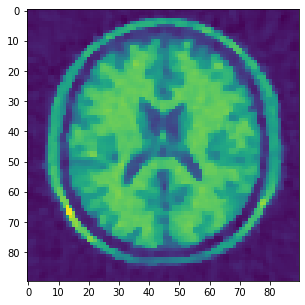

In [0]:
plt.imshow(x_mmq.reshape(90,90, order='F'))
plt.show()

### 3.3 3MG algorithm

The MM quadratic algorithm can be accelerated by using a subspace strategy. Here, we will focus on the so-called 3MG (MM Memory Gradient) approach which consists in defining the iterate $x_{k+1}$ as the minimizer of the quadratic majorant function at $x_k$ within a subspace spanned by the following directions:

$$\begin{equation}
\forall k \in \NN, \ D_k = \left[-\nabla f(x_k) \ | \ x_k - x_{k-1} \right]
\tag{5}
\end{equation}$$

(with the convention $D_0 = −\nabla f (x_0)$). Thus, an iterate of 3MG reads:

$$\begin{equation}
\forall k \in \NN, \ x_{k+1} = x_k + D_k u_k
\tag{6}
\end{equation}$$

with

$$\begin{equation}
\forall k \in \NN, \ u_k = - \( D_k^\top A(x_k) D_k \)^\dagger \(D_k^\top \nabla f (x_k) \)
\tag{7}
\end{equation}$$

where $A(x_k) \in \RR^{N \times N}$ is the curvature of the majorant matrix at $x_k$ and $\dagger$ denotes the pseudo-inverse operation.

1. Implement the 3MG algorithm.
Hint : use `pinv` in Matlab and `scipy.linalg.pinv` in Python to compute the pseudo-inverse. Given the size of the matrices, mind the order of matrix multiplications, e.g. when computing $D_k^\top H^\top H D_k$ do not compute $D_k^\top \( H^\top H \) D_k$ but $\(HD_k \)^\top \( HD_k \)$.

In [0]:
@exc_time
def MMMG(x0, f, grad_f, n_iters=int(1e5), threshold=threshold, lr=1):
    fx_lst = [f(x0)]
    x = np.copy(x0)
    D = - grad_f(x)[:,np.newaxis]
    xprev = np.copy(x)    
    for k in range(n_iters):
        grad = grad_f(x)
        HD = H @ D
        GD = G @ D
        DAD = HD.T @ HD + coef * GD.T @ scipy.sparse.diags(1 / psi(G @ x)).tocsc() @ GD
        # avoid dimensions errors on first iteration
        if DAD.ndim == 0:
            DAD = DAD.reshape(1,1)
        u = -scipy.linalg.pinv(DAD) @ D.T @ grad
        x += D @ u
        fx_lst.append(f(x))
        stopping = np.linalg.norm(grad) < threshold
        if stopping or k % 100 == 0 or k == n_iters - 1:
            print("iter {}:  \tf(x) = {:.5f}\t||∇f(x)|| = {:.5f}".format(k + 1, f(x), np.linalg.norm(grad)))
        if stopping:
            print("stopping criterion reached, stopping now")
            break        
        D = - np.vstack((grad, x - xprev)).T
        xprev = np.copy(x)
    np.save('MMMG_values.npy', np.array(fx_lst))
    return x

In [0]:
x_3mg = MMMG(x0, f, grad_f)

iter 1:  	f(x) = 264718.87082	||∇f(x)|| = 449475.95781
iter 101:  	f(x) = 13052.53666	||∇f(x)|| = 297.50736
iter 201:  	f(x) = 12982.45113	||∇f(x)|| = 15.62415
iter 301:  	f(x) = 12981.07539	||∇f(x)|| = 1.60068
iter 401:  	f(x) = 12981.06934	||∇f(x)|| = 0.12020
iter 501:  	f(x) = 12981.06928	||∇f(x)|| = 0.01809
iter 536:  	f(x) = 12981.06927	||∇f(x)|| = 0.00858
stopping criterion reached, stopping now
Time elapsed: 0min 28s.


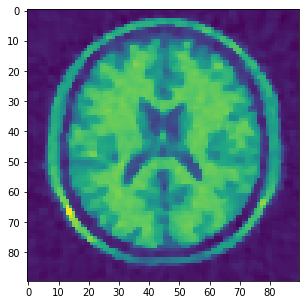

In [0]:
plt.imshow(x_3mg.reshape(90,90, order='F'))
plt.show()

### 3.4 Block-coordinate MM quadratic algorithm

*Arrays are indexed from index 0 in this notebook to be consistent with Python, whereas they are indexed from 1 in the original subject. Therefore, some formulas can be different.*

Another acceleration strategy consists in applying a block alternation technique.
The vector $x$ is divided into $J \geq 1$ blocks, with size $1 \leq N_j \leq N$. At each iteration $k \in \NN$, a block index $j \in \{0, \dots, J-1 \}$ is chosen, and the corresponding components
of $x$, denoted $x^{(j)}$, are updated, according to a MM quadratic rule. Here, we will assume that the blocks are selected in a cyclic manner, that is,

$$\begin{equation}
\forall k \in \NN, \ j = k \mod J
\tag{8}
\end{equation}$$

For a given block index $j$, the corresponding pixel indexes are updated in the image:

$$\begin{equation}
n \in \JJ_j = \left\{ j N_j, \dots, (j+1) N_j - 1\right\}
\tag{9}
\end{equation}$$

1. Create a function which gives, as an output, matrix $A_j(x) \in \RR^{N_j \times N_j}$ containing only the lines and rows of $A(x)$ with indexes $\JJ_j$.

In [0]:
def get_cols(A, j, Nj):
    return A[...,j*Nj:(j+1)*Nj]

def Aj(x, j, Nj):
    Gj, Hj = get_cols(G, j, Nj), get_cols(H, j, Nj)
    diag = scipy.sparse.diags(1 / psi(Gj @ x)).tocsc()

    def curvature(v):
        return Hj.T @ (Hj @ v) + coef * (Gj.T @ (diag @ (Gj @ v)))

    return linalg.LinearOperator((Nj,Nj), matvec=curvature, rmatvec=curvature)


2. Deduce an implementation of a block coordinate MM quadratic algorithm for minimizing $f$. Test it for $N_j = N/K$ with $K \in \{1, 2, 3, 5, 6, 9\}$.

In [0]:
@exc_time
def BMMQ(x0, f, grad_f, A, K, n_iters=int(1e5), threshold=threshold, lr=1):
    Nj = N // K
    fx_lst = [f(x0)]
    x = np.copy(x0)
    for k in range(n_iters):
        j = k % K
        xj, gradj = get_cols(x, j, Nj), get_cols(grad_f(x), j, Nj)
        xj -= lr * linalg.bicg(A(xj, j, Nj), gradj)[0]
        norm_grad_f = np.linalg.norm(grad_f(x))
        fx_lst.append(f(x))
        stopping = norm_grad_f <= threshold
        if k % 50 == 0 or k == n_iters-1 or stopping:
            print("iter {}:  \tf(x) = {:.5f}\t||∇f(x)||={:.5f}".format(k + 1, f(x), norm_grad_f))
        if stopping:
            print("stopping criterion reached, stopping now")
            break
    np.save('BMMQ_values.npy', np.array(fx_lst))
    return x

In [0]:
# K = 1 <=> classical MMQ algorithm
for K in [2, 3, 5, 6, 9]:
    print('K =', K)
    BMMQ(x0, f, grad_f, Aj, K)
    print()

K = 2
iter 1:  	f(x) = 1658109.55078	||∇f(x)||=153227.01269
iter 51:  	f(x) = 12981.10411	||∇f(x)||=2.77710
iter 101:  	f(x) = 12981.06931	||∇f(x)||=0.05359
iter 135:  	f(x) = 12981.06928	||∇f(x)||=0.00877
stopping criterion reached, stopping now
Time elapsed: 0min 44s.

K = 3
iter 1:  	f(x) = 3104930.36249	||∇f(x)||=235946.30337
iter 51:  	f(x) = 12981.64424	||∇f(x)||=20.44299
iter 101:  	f(x) = 12981.07054	||∇f(x)||=0.33361
iter 151:  	f(x) = 12981.06930	||∇f(x)||=0.04101
iter 192:  	f(x) = 12981.06928	||∇f(x)||=0.00900
stopping criterion reached, stopping now
Time elapsed: 0min 45s.

K = 5
iter 1:  	f(x) = 4546103.45225	||∇f(x)||=306140.95882
iter 51:  	f(x) = 13052.84308	||∇f(x)||=516.83009
iter 101:  	f(x) = 12981.24578	||∇f(x)||=6.67470
iter 151:  	f(x) = 12981.07533	||∇f(x)||=0.79077
iter 201:  	f(x) = 12981.06974	||∇f(x)||=0.19052
iter 251:  	f(x) = 12981.06932	||∇f(x)||=0.05764
iter 301:  	f(x) = 12981.06928	||∇f(x)||=0.01922
iter 337:  	f(x) = 12981.06928	||∇f(x)||=0.00883
st

### 3.5 Parallel MM quadratic algorithm

In order to benefit from the multicore structure of modern computer architecture, a parallel form of the MM quadratic algorithm is desirable. However, the quadratic majorizing function defined in Section 3.2 is not separable with respect to the entries of vector $x$ so that its minimization cannot be performed efficiently in a parallel manner. Here, we propose an alternative construction, that possesses a better potential for parallelization.

1. For every $x \in \RR^N$, let $B(x) \in \RR^{N \times N}$ be a diagonal matrix with elements

$$\begin{equation}
\forall i \in \{1, \dots, N \}, \ b^{(i)}(x) = \HH^\top \mathbf{1} + \lambda \GG^\top \( \frac{\phi \( Gx \)}{Gx} \)
\tag{10}
\end{equation}$$

with $\HH \in \RR^M$, $\GG \in \RR^{2N}$, and

$$\begin{equation}
\HH^{(m)} = | H^{(m,i)} | \sum_{p=1}^N | H^{(m,p)} | \qquad
\text{ and } \qquad
\GG^{(n)} = | G^{(n,i)} | \sum_{p=1}^N | G^{(n,p)} |
\tag{11}
\end{equation}$$

Prove that, for every $x \in \RR^N$, $A(x) \preceq B(x)$ where $A(·)$ was defined in Section 3.2. Hint : use Jensen’s inequality.

Let $x,y \in \RR^N$, let us show that $y^\top (B(x)-A(x)) y \geq 0$.

For $i \in \{1, \dots, N \}$, pose:
$$b^{(i)}_H(x) = \HH^\top \mathbf{1} \quad \text{and} \quad b^{(i)}_G(x) = \GG^\top \( \frac{\phi \( Gx \)}{Gx} \)$$
and $B_G(x)$ and $B_H(x)$ the corresponding diagonal matrices.

Define
$$S_G^{(n)} = \sum_{p=1}^N | G^{(n,p)} | \quad \text{and} \quad S_H^{(m)} = \sum_{p=1}^N | H^{(m,p)} |$$

Then, for all $m \in \{1, \dots, M \}$:
$$\begin{aligned}
\( \sum \limits_{i=1}^N H^{(m,i)}y^{(i)} \)^2
&\leq \( \sum \limits_{i=1}^N | H^{(m,i)} | y^{(i)} \)^2 \\
&= \( \sum \limits_{i=1}^N \frac{| H^{(m,i)} |}{S_H^{(m)}} S_H^{(m)} y^{(i)} \)^2 \\
&\leq \sum \limits_{i=1}^N \frac{| H^{(m,i)} |}{S_H^{(m)}} \( S_H^{(m)} y^{(i)} \)^2 \quad \text{by Jensen inequality} \\
&= \sum \limits_{i=1}^N \HH^{(m)}_i \(y^{(i)}\)^2
\end{aligned}$$

By summing for $m \in \{1, \dots, M \}$, follows that
$$y^\top H^\top H y \leq y^\top B_H(x) y$$

Similarly, for all $n \in \{1, \dots, 2N \}$:
$$\( \sum \limits_{i=1}^N G^{(n,i)}y^{(i)} \)^2 \leq \sum \limits_{i=1}^N \GG^{(n)}_i \(y^{(i)}\)^2$$.

Pose $\phi^{(n)}(x) = \frac{1}{\delta^2 \psi([Gx]^{(n)})}$ et $\phi(x) = \text{Diag}(\phi^{(1)}, \dots, \phi^{(2N)})$.

$$\begin{aligned}
y^\top G^\top \phi(x) G y
&= \sum \limits_{n=1}^{2N} \phi^{(n)}(x) \( \sum \limits_{i=1}^N G^{(n,i)}y^{(i)} \)^2 \\
&\leq \sum \limits_{n=1}^{2N} \sum \limits_{i=1}^N \GG^{(n)}_i \phi^{(n)}(x) \(y^{(i)}\)^2 \\
&= \sum \limits_{i=1}^N \GG^\top_i \phi(x) \(y^{(i)}\)^2 \\
&= y^\top B_G(x) y
\end{aligned}$$

Thus, by linearity:
$$y^\top \( H^\top H + \lambda G^\top \phi(x) G \) y \leq y^\top \(B_H(x) + \lambda B_G(x) \) y$$
i.e.
$$y^\top \(B(x) - A(x) \) y \geq 0$$.

Hence $A(x) \preceq B(x)$.



2. Deduce an implementation of a parallel MM quadratic algorithm or minimizing $f$.

In [0]:
G_abs, H_abs = np.abs(G), np.abs(H)
G_sum = scipy.sparse.diags(G_abs.toarray().sum(axis=1)).tocsc()
H_sum = scipy.sparse.diags(H_abs.toarray().sum(axis=1)).tocsc()
G_cal, H_cal = G_sum @ G_abs, H_sum @ H_abs
H_cal_sum = H_cal.sum(axis=0)

def B(x):
    # B(x) is stored as a vector instead of a diagonal matrix
    return np.asarray(H_cal_sum + coef * G_cal.T @ (1 / psi(G @ x))).squeeze()

@exc_time
def PMMQ(x0, f, grad_f, B, n_iters=int(1e5), threshold=threshold, lr=1):
    fx_lst = [f(x0)]
    x = np.copy(x0)
    for k in range(n_iters):
        x -= lr * 1/B(x) * grad_f(x)
        fx_lst.append(f(x))
        norm_grad_f = np.linalg.norm(grad_f(x))
        stopping = norm_grad_f <= threshold
        if k % 200 == 0 or k == n_iters-1 or stopping:
            print("iter {}:  \tf(x) = {:.5f}\t||∇f(x)|| = {:.5f}".format(k + 1, f(x), norm_grad_f))
        if stopping:
            print("stopping criterion reached, stopping now")
            break
    np.save('PMMQ_values.npy', np.array(fx_lst))
    return x

In [42]:
x_pmmq = PMMQ(x0, f, grad_f, B)

iter 1:  	f(x) = 547439.64620	||∇f(x)|| = 85252.41507
iter 201:  	f(x) = 13063.14685	||∇f(x)|| = 133.43911
iter 401:  	f(x) = 12992.50031	||∇f(x)|| = 38.92098
iter 601:  	f(x) = 12983.69106	||∇f(x)|| = 16.99097
iter 801:  	f(x) = 12981.81296	||∇f(x)|| = 8.41491
iter 1001:  	f(x) = 12981.31571	||∇f(x)|| = 4.54422
iter 1201:  	f(x) = 12981.16059	||∇f(x)|| = 2.63914
iter 1401:  	f(x) = 12981.10561	||∇f(x)|| = 1.61127
iter 1601:  	f(x) = 12981.08445	||∇f(x)|| = 1.01594
iter 1801:  	f(x) = 12981.07585	||∇f(x)|| = 0.65531
iter 2001:  	f(x) = 12981.07222	||∇f(x)|| = 0.43028
iter 2201:  	f(x) = 12981.07063	||∇f(x)|| = 0.28681
iter 2401:  	f(x) = 12981.06991	||∇f(x)|| = 0.19376
iter 2601:  	f(x) = 12981.06958	||∇f(x)|| = 0.13251
iter 2801:  	f(x) = 12981.06943	||∇f(x)|| = 0.09165
iter 3001:  	f(x) = 12981.06935	||∇f(x)|| = 0.06405
iter 3201:  	f(x) = 12981.06931	||∇f(x)|| = 0.04518
iter 3401:  	f(x) = 12981.06929	||∇f(x)|| = 0.03214
iter 3601:  	f(x) = 12981.06929	||∇f(x)|| = 0.02304
iter 3801:

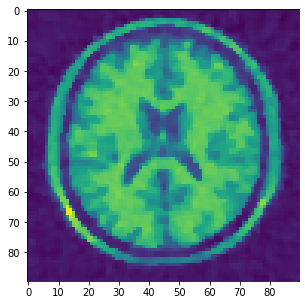

In [43]:
plt.imshow(x_pmmq.reshape(90,90, order='F'))
plt.show()

### 3.6 Comparison of the methods

1. Create a function that computes the value of the criterion $f$ along the iterations of the algorithm.

In [0]:
# already implemented in the functions

2. We will consider that the convergence is reached when the following stopping criterion is fulfilled:

$$\begin{equation}
\| \nabla f (x_k) \| \leq \sqrt{N} \times 10^{-4}
\tag{12}
\end{equation}$$

What is the required time for each method to achieve this condition ? For each method, plot the decrease of $(f(x_k))_{k \in \NN}$ versus time until the stopping criterion is satisfied.

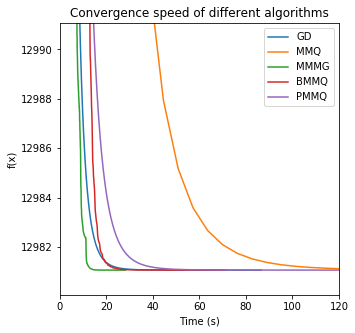

In [44]:
for algo in ['GD','MMQ','MMMG','BMMQ','PMMQ']:
    try:
        d = np.load(algo+'_time.npy')
        f_list = np.load(algo+'_values.npy')
    except OSError:
        continue
    t_list = np.linspace(0, d, len(f_list))
    plt.plot(t_list, f_list, label=algo)
plt.legend()
plt.title('Convergence speed of different algorithms')
plt.xlabel('Time (s)')
plt.ylabel('f(x)')
plt.xlim(0, 120)
plt.ylim(f_list[-1]-1, f_list[-1]+10)
plt.show()

3. The Signal to Noise Ration (SNR) of a restored image $\widehat{x}$ is defined as

$$\begin{equation}
\text{SNR} = 10 \log_{10} \( \frac{\|\bar{x}\|^2}{\| \bar{x} - \widehat{x} \|^2} \)
\tag{13}
\end{equation}$$

Using the fastest method, search for parameters $(\lambda, \delta)$ that optimize the SNR.

In [0]:
psi2 = lambda u, delta: np.sqrt(1 + (u/delta)**2)

def grad_f2(x, lbda, delta):
    Gx = G @ x
    grad = Gx / psi(Gx) @ G
    return H.T @ (H @ x - y) + lbda/(delta**2) * grad

def MMMG_quiet(x0, grad_f, lbda, delta, n_iters=int(1e5), threshold=threshold, lr=1):
    start = time.time()
    x = np.copy(x0)
    D = - grad_f(x, lbda, delta)[:,np.newaxis]
    xprev = np.copy(x)    
    for k in range(n_iters):
        grad = grad_f(x, lbda, delta)
        HD = H @ D
        GD = G @ D
        DAD = HD.T @ HD + coef * GD.T @ scipy.sparse.diags(1 / psi2(G @ x, delta)).tocsc() @ GD
        # avoid dimensions errors on first iteration
        if DAD.ndim == 0:
            DAD = DAD.reshape(1,1)
        u = -scipy.linalg.pinv(DAD) @ D.T @ grad
        x += D @ u
        norm_grad = np.linalg.norm(grad)
        if norm_grad < threshold or time.time()-start > 60:
            break        
        D = - np.vstack((grad, x - xprev)).T
        xprev = np.copy(x)
    return x

SNR = lambda x: 10*np.log10(np.sum(xbar**2)/np.sum((x-xbar)**2))

In [45]:
lambda_values = np.linspace(0.1, 1, 10)
delta_values = np.linspace(0.01, 0.1, 10)

for l in lambda_values:
    for d in delta_values:
        print('λ = {:.1f}  \tδ = {:.2f}'.format(l, d), end='\t')
        x_hat = MMMG_quiet(x0, grad_f2, l, d)
        print('SNR: {:.5f}'.format(SNR(x_hat)))

λ = 0.1  	δ = 0.01	SNR: -14.12344
λ = 0.1  	δ = 0.02	SNR: 18.96083
λ = 0.1  	δ = 0.03	SNR: 17.03969
λ = 0.1  	δ = 0.04	SNR: 14.49281
λ = 0.1  	δ = 0.05	SNR: 12.60176
λ = 0.1  	δ = 0.06	SNR: 11.22490
λ = 0.1  	δ = 0.07	SNR: 10.15099
λ = 0.1  	δ = 0.08	SNR: 9.23751
λ = 0.1  	δ = 0.09	SNR: 8.47871
λ = 0.1  	δ = 0.10	SNR: 7.86986
λ = 0.2  	δ = 0.01	SNR: -31.95293
λ = 0.2  	δ = 0.02	SNR: 18.76065
λ = 0.2  	δ = 0.03	SNR: 18.85268
λ = 0.2  	δ = 0.04	SNR: 17.48778
λ = 0.2  	δ = 0.05	SNR: 15.61250
λ = 0.2  	δ = 0.06	SNR: 13.97268
λ = 0.2  	δ = 0.07	SNR: 12.68265
λ = 0.2  	δ = 0.08	SNR: 11.65305
λ = 0.2  	δ = 0.09	SNR: 10.81074
λ = 0.2  	δ = 0.10	SNR: 10.09498
λ = 0.3  	δ = 0.01	SNR: 10.58285
λ = 0.3  	δ = 0.02	SNR: 18.07838
λ = 0.3  	δ = 0.03	SNR: 19.03839
λ = 0.3  	δ = 0.04	SNR: 18.60312
λ = 0.3  	δ = 0.05	SNR: 17.33763
λ = 0.3  	δ = 0.06	SNR: 15.79818
λ = 0.3  	δ = 0.07	SNR: 14.40086
λ = 0.3  	δ = 0.08	SNR: 13.24876
λ = 0.3  	δ = 0.09	SNR: 12.29839
λ = 0.3  	δ = 0.10	SNR: 11.50470
λ = 0.4  	δ

In [47]:
lambda_values = np.linspace(0.45, 0.55, 11)
delta_values = [0.04]

for l in lambda_values:
    for d in delta_values:
        print('λ = {:.2f}  \tδ = {:.2f}'.format(l, d), end='\t')
        x_hat = MMMG_quiet(x0, grad_f2, l, d)
        print('SNR: {:.5f}'.format(SNR(x_hat)))

λ = 0.45  	δ = 0.04	SNR: 19.02300
λ = 0.46  	δ = 0.04	SNR: 19.02983
λ = 0.47  	δ = 0.04	SNR: 19.03507
λ = 0.48  	δ = 0.04	SNR: 19.03885
λ = 0.49  	δ = 0.04	SNR: 19.04133
λ = 0.50  	δ = 0.04	SNR: 19.04256
λ = 0.51  	δ = 0.04	SNR: 19.04253
λ = 0.52  	δ = 0.04	SNR: 19.04140
λ = 0.53  	δ = 0.04	SNR: 19.03931
λ = 0.54  	δ = 0.04	SNR: 19.03625
λ = 0.55  	δ = 0.04	SNR: 19.03224


It seems that choosing $\lambda = 0.5$ and $\delta = 0.04$ optimizes the SNR.